In [2]:
bayesplay::loadpackages()

# The evidential alternative to *p* values 

Coming up with an alternative to *p* values requires us to rearrange our thinking a bit. So let's first **again** get straight what we're doing with frequentist inference. In frequentist inference we set some parameter to a certain value ($\theta$), we then generate data from imaginary experiments using that parameter setting, and we then compare our data to the data from those experiments and ask: "how consistent is our data with the data that would be generated if the parameter was actually $\theta$? At no point are we making inferences *about the value* of $\theta$. We **set** the value. 

To think about what an alternative might look like, let us think back to our earlier example on the different meanings of probability. With *p*-values we thought about probability in terms of relative frequency. We were asking "how often?" questions. But I also mentioned another example. The example of being 90% sure that the accused committed a crime. If we want to be rational humans, when we make claims like this, what we usually do is examine the evidence. We compare whether there is more evidence for the accused's guilt or the accused' innocence. That is, we take the courtroom evidence and examine whether it supports hypothesis 1 (the accused is guilty) or hypothesis 2 (the accused is innocent). But what is statistical evidence?

## A theory of statistical evidence 

To understand the concept of statistical evidence, let's go back to our coin flipping example. In our coin flipping example, we collected 10 flips and found 8 heads and 2 tails. Our frequentist analysis asked something like, " how consistent is **this** data with the data that would've been generated if the bias **was 0.5?**" But we could ask another question. That question might go something like this: "**Given this data**, is it more likely that the **bias is 0.6** or that the **bias is 0.8**?"

To answer this question, we'll set our parameter $\theta$ to the values between 0 and 1. For each setting, we'll simulate a bunch of experiments, and then we'll ask, "how often did our **exact** result (8 heads in 10 flips) occur with that setting of $\theta$?" We'll also do it twice. In one version, we will flip the coin 10 times. In the other version, we'll carry on flipping until we get two tails.  I'm also going to cheat slightly. I'm not actually going to simulate the results. I know the distribution they'll follow, so I'll just compute the distributions directly.


In [3]:
#1 

# set up the functions that plot the distributions of results for 
# various values of pr_heads

# function v1 "simulates" results from the version where you
# flip the coin n times and then count up the heads. 
# three parameters need to be set
# 1. the number of flips (n_flips)
# 2. the probability of heads (pr_heads)
# 3. the number of heads in our observation (obs_heads)

coin_flip_v1 = function(n_flips, pr_heads, obs_heads){

  pmap_df(tibble(heads = 1:n_flips, flips = n_flips, pr_heads = pr_heads), # input values
    
 function(heads, flips, pr_heads)
     tibble(flips = flips, heads = heads, 
  freq = dbinom(heads, flips, pr_heads))) %>% # get the frequency 
  mutate(our_ob = case_when(flips == n_flips & heads == obs_heads ~ TRUE, TRUE ~ FALSE)) # mark our observation
    
}
            
# function v2 "simulates" results from the version where you 
# flip the coin until it comes up tails n times.
# three parameters need to be set
# 1. the number of tails to stop at (n_tails)
# 2. the probability of heads (pr_heads)
# 3. the number of flips in our observation (obs_flips)
          
coin_flip_v2 = function(n_tails,pr_heads,obs_flips){
    pmap_df(tibble(tails = n_tails, pr_heads = pr_heads, flips = 1:(obs_flips+4)), # input values
            
        function(tails, pr_heads, flips) tibble(flips = flips, tails = tails, 
        freq = dnbinom(flips - tails, tails, 1 - pr_heads))) %>% 
  mutate(our_ob = case_when(flips == obs_flips  & tails == tails ~ TRUE, TRUE ~ FALSE)) # mark our observation
}

Once we've set up our functions, we can draw the distributions of the possible data that would occur for different values of $Pr_{\mathrm{heads}} = \theta$. I'll just pick a few. In each of the plots, our actual observation will be highlighted. Although we're "simulating" all possible observations, we only care about our **actual** observation. And we want to know the relative frequency with which **that** result occurs, not the frequency of results that didn't but might've occurred. 


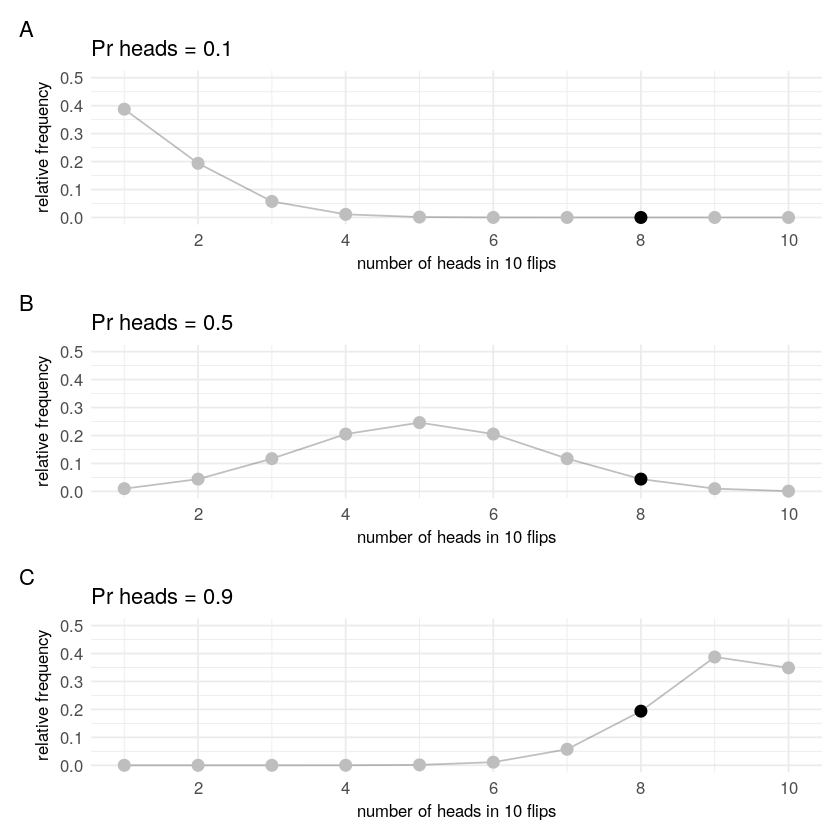

In [11]:
# 2
# draw distributions of the data for various values of pr_heads for version 1 (flip n times)

n_flips = 10
pr_heads_values = c(1/10,5/10,9/10) # set our pr_heads values
obs_heads = 8

# make the plots
coin_flip_v1_plots = pmap(tibble(n_flips = n_flips, pr_heads = pr_heads_values, obs_heads = obs_heads),
                          function(n_flips, pr_heads, obs_heads) 
                            coin_flip_v1(n_flips, pr_heads, obs_heads) %>%
                            ggplot(aes(x = heads, y = freq)) + geom_line(alpha = .25) +
                            geom_point(aes(colour = our_ob), size = 3)  +
                            scale_colour_manual(guide = "none", values = c("TRUE" = "black", "FALSE" = "grey")) + 
                            labs(x = glue("number of heads in {n_flips} flips"),
                                 y = "relative frequency", 
                                title = glue("Pr heads = {pr_heads}")) + theme_minimal())

# make the plots pretty and arrange them
coin_flip_v1_plots = map(coin_flip_v1_plots, 
    function(x) x + scale_x_continuous(breaks = seq(0,10,2)) + 
                    scale_y_continuous(limits = c(0,.5)) +
                         theme(axis.text = element_text(size = 10), 
                               axis.title = element_text(size = 10)))

patchwork::wrap_plots(coin_flip_v1_plots,nrow = 3) + plot_annotation(tag_levels = "A")

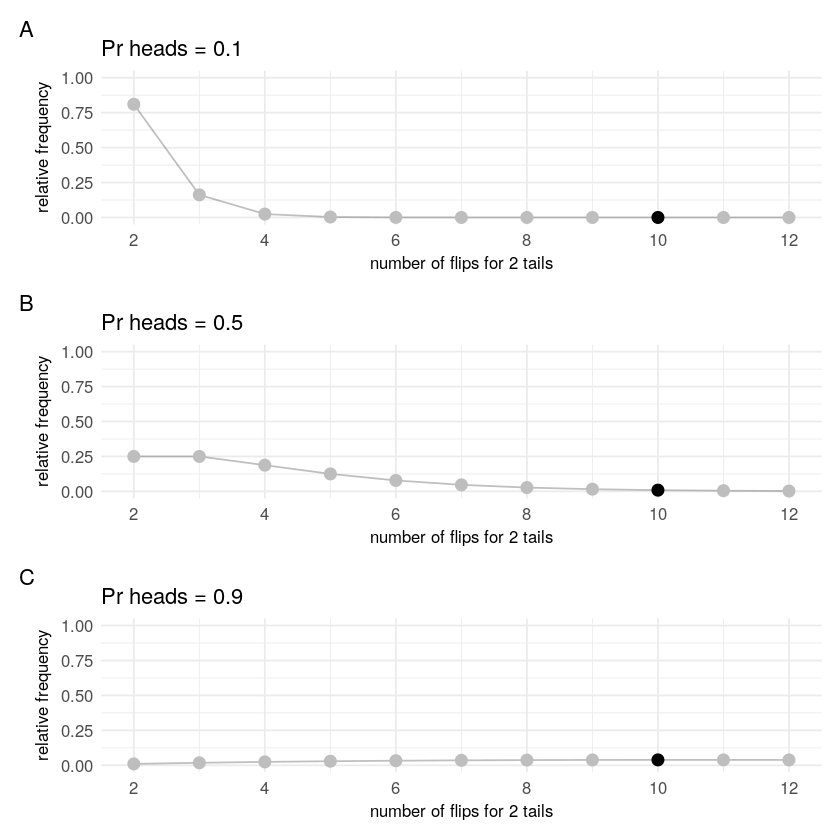

In [12]:
# 3
# draw distributions of the data for various values of pr_heads for version 2 (flip until n tails)

n_tails = 2
pr_heads_values = c(1/10,5/10,9/10) # set our pr_heads values
obs_flips = 10

# make the plots
coin_flip_v2_plots = pmap(tibble(n_tails = n_tails, pr_heads = pr_heads_values, obs_flips = obs_flips),
                          function(n_tails,pr_heads,obs_flips) 
                            coin_flip_v2(n_tails,pr_heads,obs_flips) %>%
                            ggplot(aes(x = flips, y = freq)) + geom_line(alpha = .25, na.rm = TRUE) +
                            geom_point(aes(colour = our_ob), size = 3, na.rm = TRUE) + 
                            scale_colour_manual(guide = "none", values = c("TRUE" = "black", "FALSE" = "grey")) + 
                            labs(x = glue("number of flips for {n_tails} tails"),
                                 y = "relative frequency", 
                                title = glue("Pr heads = {pr_heads}")) + theme_minimal())

# make the plots pretty and arrange them
coin_flip_v2_plots = map(coin_flip_v2_plots, 
    function(x) x + scale_x_continuous(breaks = seq(2,12,2), limits = c(2,12)) + 
                    scale_y_continuous(limits = c(0,1)) +
                         theme(axis.text = element_text(size = 10), 
                               axis.title = element_text(size = 10)))

patchwork::wrap_plots(coin_flip_v2_plots,nrow = 3) + plot_annotation(tag_levels = "A")

Since we just want to know the relative frequency of **our specific observation** so we'll draw two more plots that just show the relative frequency of *our observation* for each value of $Pr_{\mathrm{heads}}$. That is, we're going to take all the highlighted points from the plots above and put them on a single plot. We'll generate a plot for each version.


In [13]:
# 4
# first set our observation again
number_of_heads = 8
number_of_flips = 10

# and set the range of bias to consider
pr_heads_range = seq(0,1,.1) # 0/10, 1/10 ... 9/10, 10/10

# translate our observation into the parameters needed for version 1
# generate the data and pull out the relative frequency of our specific observation

n_flips = number_of_flips
obs_heads = number_of_heads
likelihood_v1 = map_df(pr_heads_range, function(x) coin_flip_v1(n_flips, x, obs_heads) %>% 
 filter(our_ob == TRUE) %>% select(freq) %>% mutate(pr_heads = x))


# translate our observation into the parameters needed for version 2
# generate the data and out the relative frequency of our specific observation
n_tails = number_of_flips - number_of_heads
obs_flips = number_of_flips
likelihood_v2 = map_df(pr_heads_range, function(x) 
    suppressWarnings( # supress warnings about impossible values 
        coin_flip_v2(n_tails,x,obs_flips) %>%
    filter(our_ob == TRUE) %>% select(freq) %>% mutate(pr_heads = x) %>%
    mutate(freq = ifelse(is.na(freq), 0, freq)))) # replace NaN (impossible values) with 0 for plotting



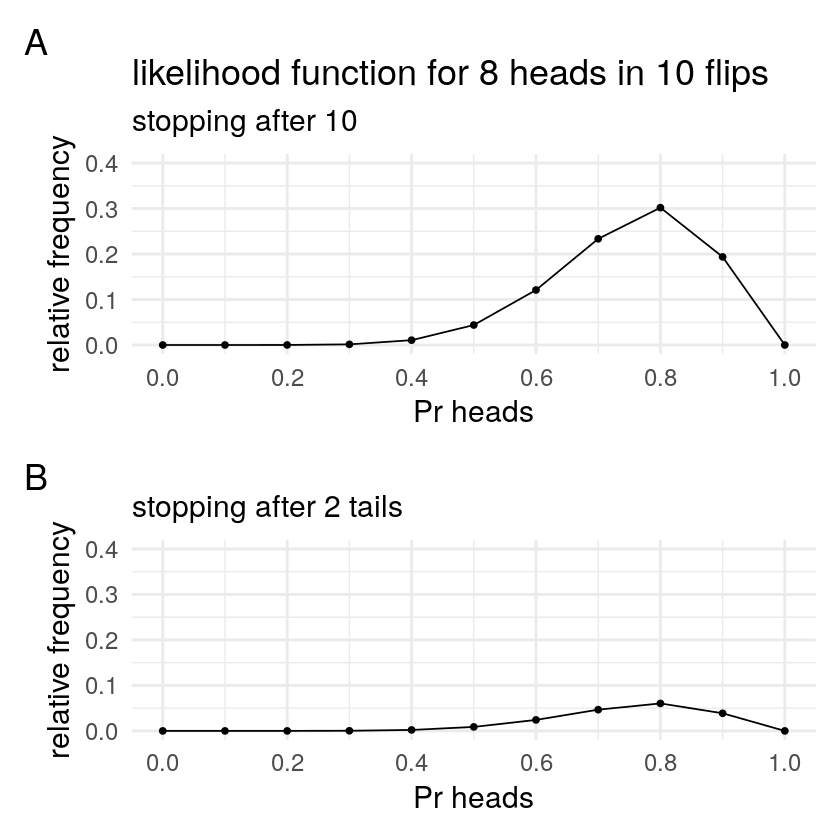

In [16]:
# 5
# now actually draw the plots

likelihood_v1_plot = likelihood_v1 %>% ggplot(aes(x = pr_heads, y = freq)) + geom_point() + geom_line() + 
theme_minimal(18) + scale_x_continuous(name = "Pr heads", breaks = seq(0,1,.2)) + 
scale_y_continuous(limits = c(0,.4), name = "relative frequency") +
labs(title = glue("likelihood function for {number_of_heads} heads in {number_of_flips} flips"),
    subtitle = glue("stopping after {number_of_flips}"))

likelihood_v2_plot = likelihood_v2 %>% ggplot(aes(x = pr_heads, y = freq)) + geom_point() + geom_line() + 
theme_minimal(18) + scale_x_continuous(name = "Pr heads", breaks = seq(0,1,.2)) + 
scale_y_continuous(limits = c(0,.4), name = "relative frequency") + 
labs(tile = glue("likelihood function for {number_of_heads} in {number_of_flips}"), 
   subtitle = glue("stopping after {n_tails} tails"))


likelihood_v1_plot / likelihood_v2_plot + plot_annotation(tag_levels = "A")

The first set of plots looked very different. This difference is mainly in terms of the relative frequency of results that **we didn't observe**. The relative frequency of the results **we did observe** is actually very similar. In the plots above they may not look that similar, but they are in fact just scaled versions of each other. We can scale them so that they match. In the scaled versions below, each plot is just scaled so that the peak is at 1. 


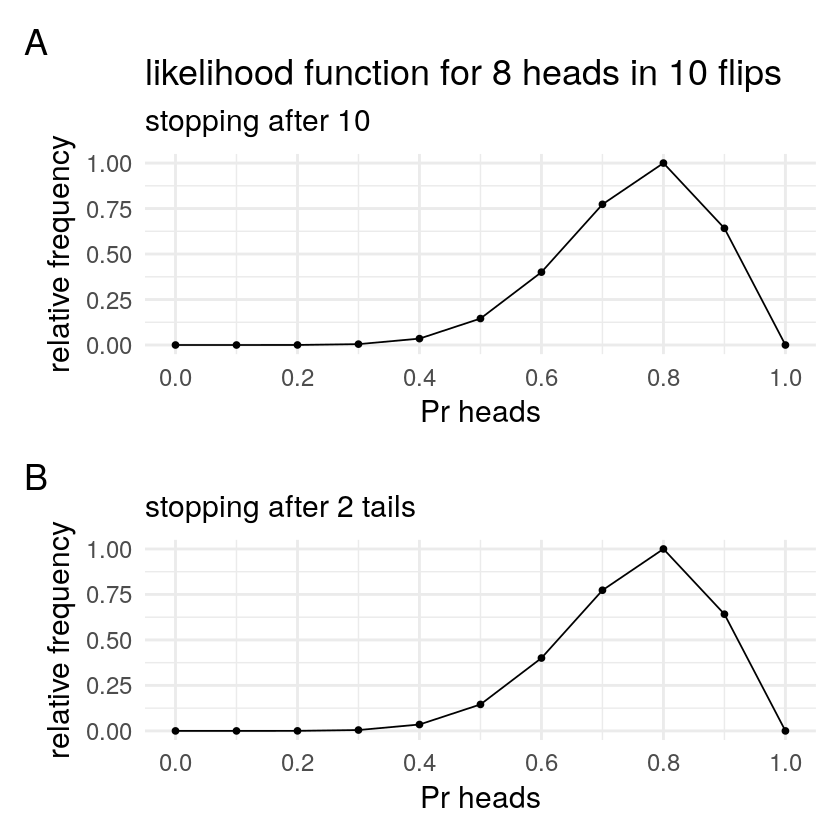

In [17]:
# 6
# now actually draw the scaled plots

likelihood_v1_plot = likelihood_v1  %>% mutate(freq = freq / max(freq)) %>%
ggplot(aes(x = pr_heads, y = freq)) + geom_point() + geom_line() + 
theme_minimal(18) + scale_x_continuous(name = "Pr heads", breaks = seq(0,1,.2)) + 
scale_y_continuous(limits = c(0,1), name = "relative frequency") +
labs(title = glue("likelihood function for {number_of_heads} heads in {number_of_flips} flips"),
    subtitle = glue("stopping after {number_of_flips}"))

likelihood_v2_plot = likelihood_v2 %>% mutate(freq = freq / max(freq)) %>%
ggplot(aes(x = pr_heads, y = freq)) + geom_point() + geom_line() + 
theme_minimal(18) + scale_x_continuous(name = "Pr heads", breaks = seq(0,1,.2)) + 
scale_y_continuous(limits = c(0,1), name = "relative frequency") + 
labs(tile = glue("likelihood function for {number_of_heads} in {number_of_flips}"), 
   subtitle = glue("stopping after {n_tails} tails"))


likelihood_v1_plot / likelihood_v2_plot + plot_annotation(tag_levels = "A")

The plots describe the relative frequency of observing **our result** given different values of the coin bias. They both show that our observation (8 heads in 10 flips) would be the most frequent observation if the coin was in fact biased to show 8 heads in 10 flips. We can call these plots **likelihood functions** and we can call the value of the bias that corresponds to the peak of the likelihood function the **maximum likelihood estimate**. 

Before we go further, it is worthwhile to pay attention to the key difference between these plots and the plots we've drawn up until now. In all our previous plots we plotted the **data** you would expect for a **given value** of a parameter (e.g., the coin bias, or where the treasuring hunting device arrow points when not around treasure). These plots show something very different. They show **relative frequency of our observation** for **different parameter values**. Put another way: In the first set of plots, we fix our parameter value while the data varies. In the second set of plots, we fix our data while the parameter varies. Or put yet another way: The first set of plots allows us to make inferences about **data**—is our data surprising on the assumption that the parameter has a specific value. The second set of plots will allow us to make inferences about **parameters**—what is the most likely value of the parameter given our specific data. 

### Some features of likelihoods 

Before we move to talk about how to use likelihoods in a notion of statistical evidence, it's worth noting a couple of things about likelihoods. First, likelihoods are **not** probability distributions. This much should already be obvious by looking at the two unscaled likelihoods above. Probability distributions have an area under the curve of 1. That is, probability distributions describe the probability of events where the probability of every possible event is given (and where at least one of the events **must** occur). Summing these values gives the probability of **an event** (any event) occurring. This value is 1. And in fact, it's given by our definition because our definition said that one of the events **must occur**. Our two likelihood functions do not **necessarily** have an area underneath equal to 1. For our two likelihoods from the coin flipping example, this is clear. Both can't have an area equal to 1 because they both obviously have different areas. Instead, what the likelihood describes is the probability of a **specific event** occurring over the range of possible parameter values. Of course, probability and likelihood are related concepts. One is just in the inverse of the other, which is why likelihood is sometimes called "inverse probability".

Below we see some examples of how the area under the curve can vary.


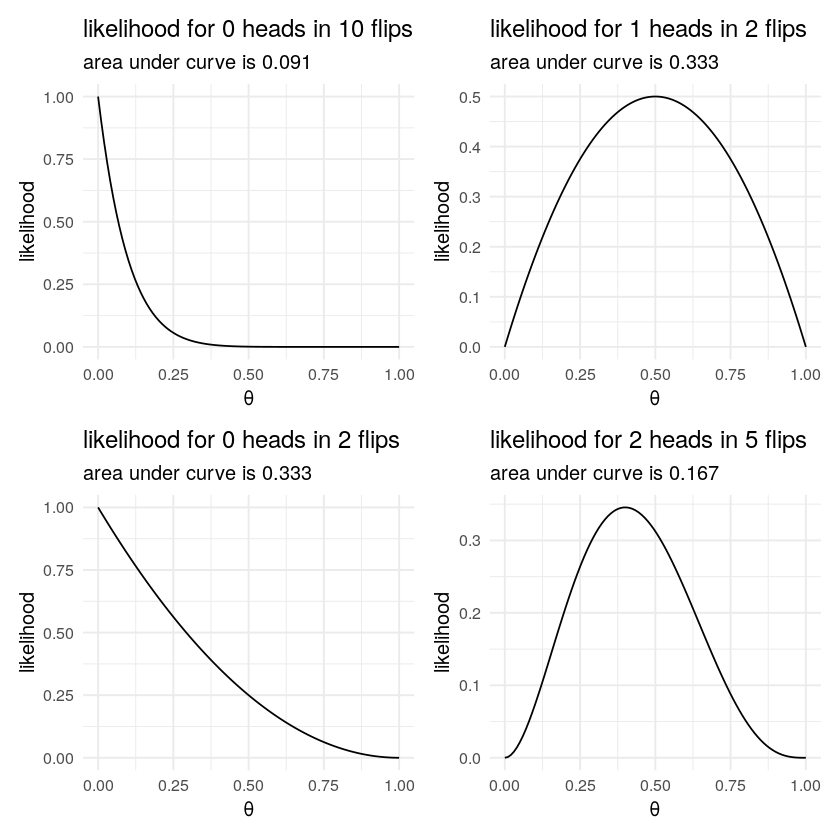

In [24]:
#7

# plot some likelihood functions 

list(p1 = c(heads = 0, flips = 10),p2 = c(heads = 1, flips = 2),p3 = c(heads = 0, flips = 2),p4 = c(heads = 2, flips = 5)) -> scenarios
map(scenarios, function(x) {dbinom.like <- function(t) dbinom(x[["heads"]],x[["flips"]],t); integrate(dbinom.like,0,1)$value %>% tibble(heads = x[["heads"]], flips = x[["flips"]], auc = .)}) -> aucs
map(aucs, function(x) ggplot(mapping = aes(x = seq(0,1,length.out = 100), y = dbinom(x$heads,x$flips,seq(0,1,length.out = 100)))) + geom_line() + labs(y = "likelihood", x = "θ", title = glue::glue("likelihood for {x$heads} heads in {x$flips} flips"), subtitle = glue::glue("area under curve is {round(x$auc,3)}")) + theme_minimal(12) ) -> plots
(plots$p1 + plots$p2) / (plots$p3 + plots$p4) 

It is also worth noting that in addition to having a peak at a certain point, likelihood functions also have a spread. We'll be talking about this spread, or variance, at a later point. 


### Likelihoods and statistical evidence

How do likelihood functions give us a notion of statistical evidence? One way to understand statistical evidence is to compare how likely our data is when $Pr_{\mathrm{heads}}$ = 0.6 and when $Pr_{\mathrm{heads}}$ = 0.8 by subtracting the two likelihood values. But because likelihoods can be on different scales, raw distances can be misleading. Instead, let us take the **ratio**. That way, we can tell how many **times** bigger one value is relative to the other. That is, are the two values the same size? Is one twice as big, three times bigger, etc. By taking the ratio we can now answer the question, "how many times more likely is our observation when $Pr_{\mathrm{heads}}$ = 0.6 relative to when $Pr_{\mathrm{heads}}$ = 0.8?" We can read this as the support our data gives to these two hypotheses.

Let's do this our observation and the likelihoods for the two versions of the coin-flipping example. Again, I won't rely on simulations (although I could). Instead, I know that the two likelihoods are drawn from a **binomial** and a **negative binomial** distribution, respectively, so I'll just generate the values. 

In [25]:
# 8 

# set out observation
n = 10 # number of flips
h = 8 # number of heads
t = n - h # number of tails

# set our two observation
h1 = 0.6 # the probability of getting heads is 0.6
h2 = 0.8 # the probability of getting heads is 0.8

L1 = dbinom(h,n, h1) 
L2 = dbinom(h,n, h2) 
glue::glue("The likelihood under $\\mathcal{{H}}_1$ ($Pr_{{heads}}$ = {h1}) is {round(L1,2)}  
The likelihood under $\\mathcal{{H}}_2$ ($Pr_{{heads}}$ = {h2}) is {round(L2,2)}   
The likelihood ratio is {round(L1/L2,2)}  
The data are {round(L1/L2,2)} times more probable under $\\mathcal{{H}}_1$ than $\\mathcal{{H}}_2$") %>% 
IRdisplay::display_markdown()

The likelihood under $\mathcal{H}_1$ ($Pr_{heads}$ = 0.6) is 0.12  
The likelihood under $\mathcal{H}_2$ ($Pr_{heads}$ = 0.8) is 0.3   
The likelihood ratio is 0.4  
The data are 0.4 times more probable under $\mathcal{H}_1$ than $\mathcal{H}_2$

In [26]:
# 9 

# Set our observation
n = 10 # number of flips
h = 8 # number of heads
t = n - h # number of tails

# set our two hypotheses
h1 = 0.6 # the probability of getting heads is 0.6
h2 = 0.8 # the probability of getting heads is 0.8

L1 = dnbinom(t,h,h1)
L2 = dnbinom(t,h,h2)
glue::glue("The likelihood under $\\mathcal{{H}}_1$ ($Pr_{{heads}}$ = {h1}) is {round(L1,2)}  
The likelihood under $\\mathcal{{H}}_2$ ($Pr_{{heads}}$ = {h2}) is {round(L2,2)}   
The likelihood ratio is {round(L1/L2,2)}  
The data are {round(L1/L2,2)} times more probable under $\\mathcal{{H}}_1$ than $\\mathcal{{H}}_2$") %>% 
IRdisplay::display_markdown()

The likelihood under $\mathcal{H}_1$ ($Pr_{heads}$ = 0.6) is 0.1  
The likelihood under $\mathcal{H}_2$ ($Pr_{heads}$ = 0.8) is 0.24   
The likelihood ratio is 0.4  
The data are 0.4 times more probable under $\mathcal{H}_1$ than $\mathcal{H}_2$

One thing you'll notice is that regardless of the experiment type (flipping 10 times or flipping until 2 tails) the support for one hypothesis over the other is the same. This shouldn't be surprising, because what lead to different inferences under the frequentist analysis was data that could've occurred but didn't. Since we're now only interested in the actual event that happened, these possible, but not actual, events don't come in to play. 

So comparing likelihoods (by taking their ratio) can tell us which hypothesis is better supported by the data. However, there's a couple of problems with this. First, how do we know when we have enough evidence? To answer this question, we're going to have to take into account a lot of additional factors. And the answer to this question is probably going to be context-dependent. For example, if we're placing bets on hypotheses, we're probably going to want to take into account the relative pay-offs. If we're using evidence to decide somebody's guilt in a court case, we're probably going to want to take into account things like "reasonable doubt". In short, there's not a straight forward answer to this question, so we'll set it aside for now. Instead, we'll turn to the second problem. 

The second problem with this method is that it only works for comparing two hypotheses. We can can say, for example, whether the data supports $Pr_{\mathrm{heads}}$ = 0.5 over the hypothesis $Pr_{\mathrm{heads}}$ = 0.8, and we can quantify this level of support. But usually, we are not comparing two simple hypotheses like this. Our hypotheses take a more complex form like: "Is the coin fair?"

How might we go about answering this question?

Let's formalise this idea a bit. First, we'll drop the terminology *hypothesis*, and replace it with *model* (denoted $\mathcal{M}_H$. And we'll say that our data favours $\mathcal{M_1}$ over $\mathcal{M_2}$ by a factor of $\frac{\mathcal{M}_1}{\mathcal{M}_2}$. And second, we'll say that the value of $\mathcal{M}_H$ is going to be the average likelihood of all the $n$ sub-hypotheses ($\Theta=\left \{ \theta_1, \theta_2,\ldots\theta_n\right \}$) that make up $\mathcal{H}_M$. Or, 

 $$\mathcal{M}_H = \sum_{i=1}^{n}\mathcal{L}_H(\theta_i|\mathbf{y})\cdot{}\frac{1}{n}$$   
 
From this, we can build a model of a fair coin, which might only have one sub-hypothesis (i.e., $\theta$ = 0.5). And we might want to compare that to a model that says the coin can can have a bias that takes any values from $\frac{0}{10}$ to $\frac{10}{10}$ (i.e., $\theta = \{\frac{0}{10},\frac{1}{10},\frac{2}{10},\frac{3}{10},\frac{4}{10},\frac{5}{10},\frac{6}{10},\frac{7}{10},\frac{8}{10},\frac{9}{10},\frac{10}{10}\}$).

 Let's try to do that. We don't need to do it for both versions any more. We can just do it for one of the versions because now we know that they're same!
 


In [27]:
# 10
# Set our observation
n = 10 # number of flips
h = 8 # number of heads


# set our two hypotheses
h1 = 0.5 # the probability of getting heads is 0.5
h2 = seq(0,1,.1) # the probability of getting heads is all possible values from 0/10 to 10/10 in steps of 1/10

M0 = dbinom(h,n, h1)
M1 = dbinom(h,n, h2); M1 = mean(M1)


glue::glue("The likelihood under $\\mathcal{{M}}_0$ is {round(M0,2)}  
The likelihood under $\\mathcal{{M}}_1$ is {round(M1,2)}   
The likelihood ratio is {round(M0/M1,2)}  
The data are {round(M0/M1,2)} times more probable under $\\mathcal{{M}}_0$ than $\\mathcal{{M}}_1$   
The data are {round(M1/M0,2)} times more probable under $\\mathcal{{M}}_1$ than $\\mathcal{{M}}_0$") %>% 
IRdisplay::display_markdown()


The likelihood under $\mathcal{M}_0$ is 0.04  
The likelihood under $\mathcal{M}_1$ is 0.08   
The likelihood ratio is 0.53  
The data are 0.53 times more probable under $\mathcal{M}_0$ than $\mathcal{M}_1$   
The data are 1.87 times more probable under $\mathcal{M}_1$ than $\mathcal{M}_0$

### Are all sub-hypotheses equal?
 
  Now that we have a way to compare two models that might be composed of one or more sub-hypotheses, we might reasonably ask, "are all sub-hypotheses equal?". That is, do we want to just take a regular average over all the sub-hypotheses or might we instead want to take a *weighted* average? 
  
  One good reason for taking a *weighted average* is that it allows us to take into account our views about what it *means* for a coin to be biassed or unfair. For example, we might think that if coins are biassed, then they're much more likely to show heads. Or we might think that if a coin is biased, it is much less likely to show heads. Or maybe biased coins are only slightly more likely to show a preponderance of heads or tails. We can capture this view by weighting some sub-hypothesis more than others before taking our average.
  
In fact, in our first calculation, we did apply a weighting, but it was hidden. But we can make it explicit. For $\mathcal{M}_0$ we can give the sub-hypothesis $\theta$ = 0.5 a weight of 1, and all others possible sub-hypotheses a weight of 0. For $\mathcal{M}_1$, we can give each of the $n$ sub-hypotheses a weight of $\frac{1}{n}$. Ideally, we want all the weights to sum to 1. This way, we can think of the weights as a probability distribution. 
  
 Usually these weights, or the weighting distribution, is refereed to as a **prior** (or occasionally as the *model of the hypothesis*). We can make these weights explicit by adding them in to our equation for $\mathcal{M}_H$. Our equation now becomes:
 
 $$\mathcal{M}_H = \sum_{i=1}^{n}\mathcal{L}_H(\theta_i|\mathbf{y})\cdot{}p(\theta_i)$$   
 
Let's explicitly adds the weights that were only implicit before. We'll see that adding these weights scales down both our likelihood values, but it produces the ratio and hence the same result.

In [28]:
# 11

# Set our observation
n = 10 # number of flips
h = 8 # number of heads


# set our two hypotheses
h1 = seq(0,1,.1) # the probability of getting heads is all possible values from 0/10 to 10/10 in steps of 1/10
h2 = seq(0,1,.1) # the probability of getting heads is all possible values from 0/10 to 10/10 in steps of 1/10

# set out weightings
w1 = c(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0) # set the weights
w1 = w1 / sum(w1) # make sure weights sum to 1

w2 = c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1) # set the weights
w2 = w2 / sum(w2) # make sure weights sum to 1
         

M = dbinom(h,n, h1) # generate the likelihood

M0 = sum(M * w1) # take a weighted average of the likelihood
M1 = sum(M * w2) # take a weighted average of the likelihood



glue::glue("The likelihood under $\\mathcal{{M}}_0$ is {round(M0,2)}  
The likelihood under $\\mathcal{{M}}_1$ is {round(M1,2)}   
The likelihood ratio is {round(M0/M1,2)}  
The data are {round(M0/M1,2)} times more probable under $\\mathcal{{M}}_0$ than $\\mathcal{{M}}_1$   
The data are {round(M1/M0,2)} times more probable under $\\mathcal{{M}}_1$ than $\\mathcal{{M}}_0$") %>% 
IRdisplay::display_markdown()

The likelihood under $\mathcal{M}_0$ is 0.04  
The likelihood under $\mathcal{M}_1$ is 0.08   
The likelihood ratio is 0.53  
The data are 0.53 times more probable under $\mathcal{M}_0$ than $\mathcal{M}_1$   
The data are 1.87 times more probable under $\mathcal{M}_1$ than $\mathcal{M}_0$

Now that we're adding in these *weighting* **priors**, the ratio of $\frac{\mathcal{M}_1}{\mathcal{M}_2}$ is usually called a **Bayes factor**. Once we make these weightings explicit by adding a *prior* we can see the that for a **particular observation** or set of data, the ratio, or **Bayes factor** is *completely* dependent on our choice of the *prior* for $\mathcal{M}_0$ and $\mathcal{M}_1$. This is why it sometimes makes more sense to think of *priors* as **models of hypotheses**. And our **Bayes factor** tells us which **model** is better supported by the data. 

We can see this dependence in the example below. In each of the four quadrants, I've held the Data ($\mathbf{y}$) and model that represents the fair coin ($\mathcal{M}_0$) constant. However, I've simply varied $\mathcal{M}_1$. Each one of these $\mathcal{M}_1$'s presents different views of what **it means for a coin to be unfair**. Each plot shows the distribution of weightings and the resulting **Bayes factor**. As you can see, when the prior changes the **Bayes factor** changes.

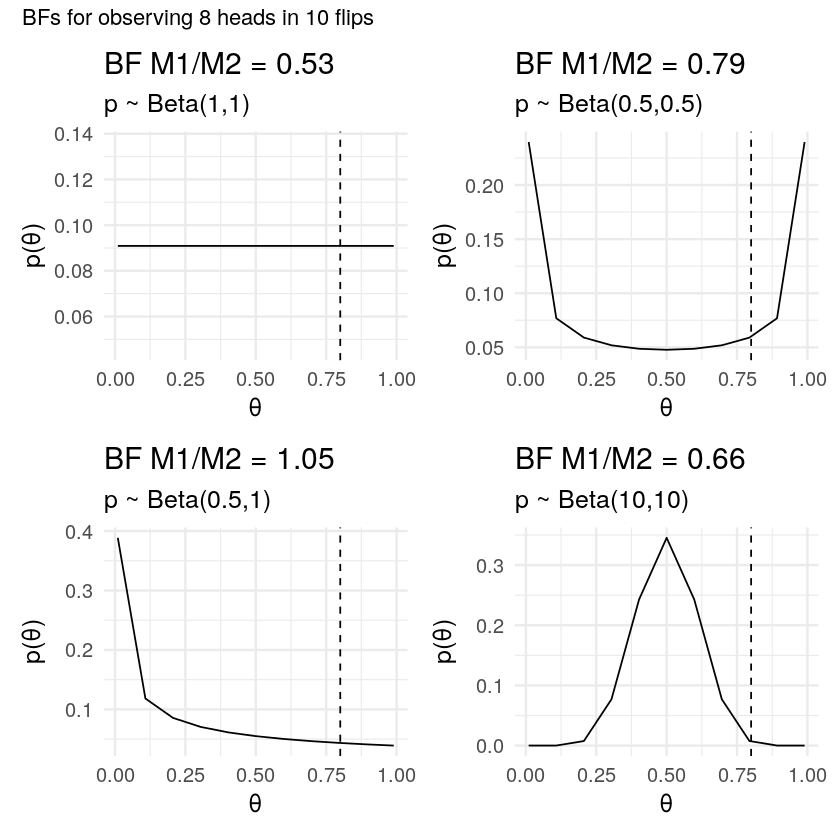

In [31]:
# 12

# define function for calculating bayes factor for coin flip example
# function takes 4 inputs
# n_heads: the number of heads observed
# n_flips: the number of flips performed
# A : the first shape parameter of the beta distribution prior
# B : the second shape parameter of the beta distribution prior
bf_func<-function(n_heads,n_flips,A,B){
    
    t = 1/n_flips # set the step size of the theta range
    theta_range = seq(0.01,.99,length.out = n_flips + 1) # set the range of thetas
    theta_range = unique(c(0.5, theta_range)) # make sure the theta range contains 0.5! (for the null)

    w1 = map_dbl(theta_range, function(x) ifelse(x == 0.5, 1, 0)) # set the weights of hypothesis 1 (null)
    w2 = (dbeta(x = theta_range,A,B)) /          # set weights of hypothesis 2 (alternative) using a
                 sum(dbeta(x = theta_range,A,B)) # beta distribution


                             
    Likelihood = dbinom(n_heads,n_flips,theta_range) # define the likelihood function

                         
    M1 =  Likelihood * w1 # multiply the likelihood by prior 1
  
 
    M2 = Likelihood * w2 # multiply the likelihood by prior 2
    BF = (sum(M1) / sum(M2)) # work out the bayes factor
  
    dat = tibble(x = theta_range, y = w2) # prepare data for ploting
    ggplot(data = dat, aes(x = x, y = y)) + 
       geom_line() + 
        geom_vline(xintercept = n_heads/n_flips, linetype = 2) + # mark the observation
    labs(x = "θ", y = "p(θ)", title = glue::glue("BF M1/M2 = {round(BF,2)}"),
         subtitle = glue::glue("p ~ Beta({A},{B})")) + 
    theme_minimal(15) # plot the prior

}
                 
n_heads = 8; n_flips = 10; # set the observation

bf_func(n_heads,n_flips,1,1) +
bf_func(n_heads,n_flips,.5,.5) +
bf_func(n_heads,n_flips,.5,1) +
bf_func(n_heads,n_flips,10,10) %>% 
  wrap_plots() + plot_annotation(title = glue::glue("BFs for observing {n_heads} heads in {n_flips} flips"))

This fact shouldn't be alarming. A **Bayes factor** is going to tell you whether your data provide evidence for *one model* over *another model*. Change the models, and your data will say something different. This also highlights that the two hypotheses/models **always** have to be specified. There's no such thing as **the null** hypothesis or **the alternative** hypothesis—only the two that have been specified. 

Because **Bayes factors** are dependent on **priors**, it pays to think carefully about them. There are many schools of thought about how one should go about formulating priors. Some of these might include:

1. Choosing priors that reflect our *genuine beliefs about the state of the world*. For example, our beliefs about **what it means** for a coin to be unfair. 
2. Choosing priors that reflect our ignorance about the state of the world. For example, our belief that we have no grounds for favouring one parameter value (sub-hypothesis) over another. We might view this as giving the data the best opportunity to speak for itself. 
3. Choosing priors that have specific (or useful) mathematical properties. 
4. Choosing priors that have been tuned such that our **Bayes factor** tests will have good *frequentist* properties—for example, that they produce BFs that is some sense *line up* with *p*-values 

This, again,  is not meant to be an exhaustive list. People might have other reasons for choosing the priors they do. And some prior choice might have multiple motivations. But this rough categorisation will do for our purposes. In the next section, we'll examine some of these strategies so that we can understand their implications. And we'll also try our hand at calculating Bayes factors for some data of the sort we get in psychology experiments (rather than silly coin flips!). But before we get to that, let's cover something that we haven't covered yet—**Bayes Rule**.
